In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Загружаем исторические значения 
currency_history = pd.read_excel('currency_history.xlsx')
currency_history = currency_history.set_index('data')
print(currency_history)

            nominal     curs         cdx
data                                    
2018-05-05        1  63.2012  Доллар США
2018-05-08        1  62.7148  Доллар США
2018-05-09        1  63.0066  Доллар США
2018-05-11        1  62.5229  Доллар США
2018-05-12        1  61.7354  Доллар США
...             ...      ...         ...
2023-04-28        1  81.5601  Доллар США
2023-04-29        1  80.5093  Доллар США
2023-05-03        1  79.9609  Доллар США
2023-05-04        1  79.3071  Доллар США
2023-05-05        1  78.6139  Доллар США

[1233 rows x 3 columns]


In [3]:
# Считаем ежедневные изменения курса в процентах
data = pd.DataFrame()
data['Return'] = currency_history['curs']
data['Return'] = 100 * (currency_history['curs'].pct_change())
data.dropna(inplace=True)
print(data)

              Return
data                
2018-05-08 -0.769606
2018-05-09  0.465281
2018-05-11 -0.767697
2018-05-12 -1.259539
2018-05-15  0.053454
...              ...
2023-04-28 -0.082448
2023-04-29 -1.288375
2023-05-03 -0.681164
2023-05-04 -0.817650
2023-05-05 -0.874071

[1232 rows x 1 columns]


Text(0.5, 1.0, 'Daily Returns Over Time')

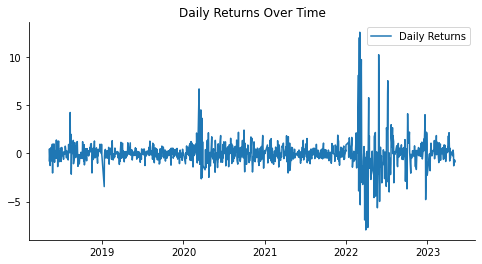

In [4]:
fig,ax = plt.subplots(figsize=(8,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(data, label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')

In [5]:
# Считаем историческую волатильность 
daily_volatility = data['Return'].std()
montly_volatility = np.sqrt(31) * daily_volatility
annual_volatility = np.sqrt(365) * daily_volatility

from tabulate import tabulate

print(tabulate([['USD/RUB',daily_volatility,montly_volatility,annual_volatility]],headers = ['Daily Volatility %','Monthly Volatility %','Annual Volatility %'],tablefmt='fancy_grid',stralign='center',numalign='center',floatfmt='.2f'))

╒═════════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│         │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═════════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ USD/RUB │         1.33         │          7.41          │         25.44         │
╘═════════╧══════════════════════╧════════════════════════╧═══════════════════════╛


In [6]:
# Импортируем библиотеку с моделью прогнозирования
from arch import arch_model
from arch.__future__ import reindexing

In [8]:
# Обучаем модель (эмпирически выяснилось, что чем больше прошлых значений ряда и дисперсии учитываем, тем точнее прогноз)
# Причем лучшая точность достиглась при p=q; однако при параметрах > 365 слишком возрастает длительность обучения модели
garch_model = arch_model(data,p=365,q=365,mean='constant',vol='GARCH',dist='normal')
gm_result = garch_model.fit(disp='off', options={'maxiter': 500})
print(gm_result.params)

mu          -0.002485
omega        0.002690
alpha[1]     0.210461
alpha[2]     0.111270
alpha[3]     0.085075
               ...   
beta[361]    0.000002
beta[362]    0.000002
beta[363]    0.000002
beta[364]    0.000002
beta[365]    0.000002
Name: params, Length: 732, dtype: float64


In [9]:
# Получаем прогнозное значение волатильности
HORIZON = 1016
predictions = []
gm_forecast = gm_result.forecast(horizon=HORIZON)
for i in range(HORIZON):
    predictions.append(np.sqrt(gm_forecast.variance.values[0][i]))
results = pd.Series(predictions)
print('Прогнозная годовая волатильность:', results.iloc[-1]*np.sqrt(365))

Прогнозная годовая волатильность: 24.511506264168457


Text(0.5, 1.0, 'Predictions')

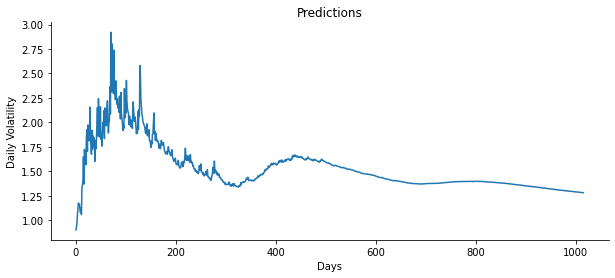

In [12]:
fig, ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
ax.set_xlabel("Days")
ax.set_ylabel("Daily Volatility")
plt.plot(predictions)
plt.title('Predictions')

In [13]:
# Протестируем точность модели GARCH (скользящий прогноз)
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = data['Return'][:-(test_size-i)]
    model = arch_model(train,p=1,q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [14]:
rolling_predictions = pd.Series(rolling_predictions, index=data['Return'].index[-365:])
print(rolling_predictions)

data
2021-11-10    0.606871
2021-11-11    0.574842
2021-11-12    0.631942
2021-11-13    0.661677
2021-11-16    0.712106
                ...   
2023-04-28    0.493899
2023-04-29    0.471584
2023-05-03    0.781305
2023-05-04    0.774801
2023-05-05    0.801418
Length: 365, dtype: float64


Text(0.5, 1.0, 'Rolling Predictions')

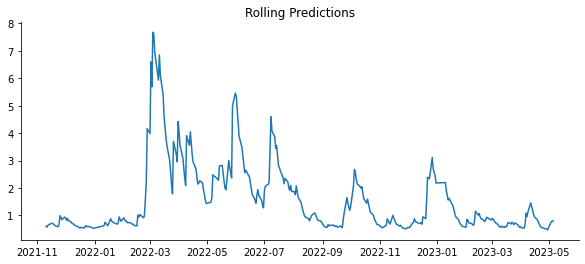

In [15]:
fig, ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Predictions')

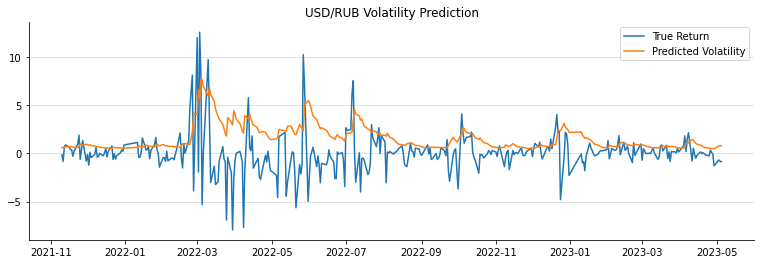

In [16]:
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which='major',axis='y',color='#758D99',alpha=0.3,zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(data['Return'][-365:])
plt.plot(rolling_predictions)
plt.title('USD/RUB Volatility Prediction')
plt.legend(['True Return','Predicted Volatility'])

In [17]:
# Протестируем точность модели GARCH (нескользящий прогноз)
predictions = []
test_size = 157

train = data['Return'][:-(test_size)]
model = arch_model(train,p=365,q=365)
model_fit = model.fit(disp='off', options={'maxiter': 500})
pred = model_fit.forecast(horizon=365)
for i in range(test_size):
    predictions.append(np.sqrt(pred.variance.values[-1,:][i]))

In [18]:
predictions = pd.Series(predictions, index=data['Return'].index[-157:])
print(predictions)

data
2022-09-15    1.363798
2022-09-16    1.628923
2022-09-17    1.421081
2022-09-20    1.343610
2022-09-21    1.668377
                ...   
2023-04-28    2.108963
2023-04-29    2.308822
2023-05-03    2.126592
2023-05-04    2.239515
2023-05-05    2.098399
Length: 157, dtype: float64


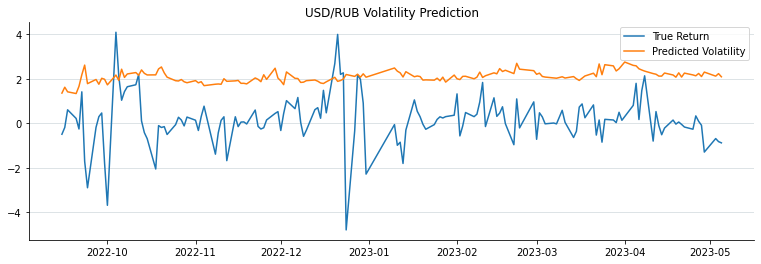

In [19]:
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which='major',axis='y',color='#758D99',alpha=0.3,zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(data['Return'][-157:])
plt.plot(predictions[-157:])
plt.title('USD/RUB Volatility Prediction')
plt.legend(['True Return','Predicted Volatility'])